In [84]:
'''Importing basic data analysis packages'''
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
warnings.filterwarnings('ignore')
os.getcwd()

'''Plotting packages'''
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)

p1 = pd.read_csv('p1.csv')
print('PLEDGE 1% cols: {}\nSHAPE: {}\n'.format(p1.columns.to_list(), p1.shape))

#################
# Organizations #
#################
print('*'*100)

ppl = pd.read_csv('people.csv')
print('PEOPLE cols: {}\nSHAPE: {}\n'.format(ppl.columns.to_list(), ppl.shape))

jobs = pd.read_csv('jobs.csv') # All jobs affiliated with company
print('JOBS cols: {}\nSHAPE: {}'.format(jobs.columns.to_list(), jobs.shape))

org = pd.read_csv('organizations.csv')
print('ORGANIZATION/org cols: {}\nSHAPE: {}\n'.format(org.columns.to_list(), org.shape))

invest = pd.read_csv('investments.csv')
print('INVESTMENTS/invest cols: {}\nSHAPE: {}\n'.format(invest.columns.to_list(), invest.shape))

fund_rnds = pd.read_csv('funding_rounds.csv')
print('FUNDING ROUNDS/fund_rnds cols: {}\nSHAPE: {}\n'.format(fund_rnds.columns.to_list(), fund_rnds.shape))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

PLEDGE 1% cols: ['uuid', 'p1_tag', 'p1_date']
SHAPE: (7822, 3)

****************************************************************************************************
PEOPLE cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'first_name', 'last_name', 'gender', 'country_code', 'state_code', 'region', 'city', 'featured_job_organization_uuid', 'featured_job_organization_name', 'featured_job_title', 'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url']
SHAPE: (1055813, 22)

JOBS cols: ['job_uuid', 'person_uuid', 'person_name', 'org_uuid', 'org_name', 'started_on', 'ended_on', 'is_current', 'title', 'job_type', 'p1_tag', 'p1_date']
SHAPE: (1536376, 12)
ORGANIZATION/org cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url', 'country_code', 'state_code', 'region', 'city', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list',

In [99]:
# merge org and p1 datasets
df_org = pd.merge(org.copy(),p1.copy(),how='inner',on='uuid')

df_org['p1_tag'] = df_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
df_org['employee_count'] = df_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
df_org = df_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

In [100]:
# only select p1 companies 
df_org = reduce_mem_usage(df_org)
df_org = df_org[df_org['p1_tag'] == 1].sort_values('p1_date')

Mem. usage decreased to  0.37 Mb (23.4% reduction)


In [101]:
# join org and funding_rounds to get funding_rounds info for a particular organization
df_org['org_uuid'] = df_org['uuid']
df_org = pd.merge(df_org.copy(),fund_rnds.copy(),on='org_uuid')

In [102]:
# only filter organization records from investor
df_invest = invest[invest['investor_type'] == 'organization']

In [103]:
# reduce memory
df_org = reduce_mem_usage(df_org)

# select attributes
df_org = df_org[['funding_round_uuid','org_uuid','name','investment_type',
                'rank','status','p1_date_x','total_funding_usd', \
                         'p1_tag_x','raised_amount_usd','post_money_valuation_usd', \
                       'lead_investor_uuids']]


# merge df_org with invest dataset on funding_round_uuid
df_org = pd.merge(invest.copy(),df_org.copy(),on='funding_round_uuid')
df_org = reduce_mem_usage(df_org)

# if a lead investor add 1 else 0
df_org.loc[df_org['is_lead_investor'] == True, 'lead_count'] = 1 
df_org.loc[df_org['is_lead_investor'] != True, 'lead_count'] = 0

# filter the records that do not have a matching funding_round_uuid
df_org = df_org[~df_org['funding_round_uuid'].isna()].sort_values('p1_date_x')

Mem. usage decreased to  0.83 Mb (17.9% reduction)
Mem. usage decreased to  2.53 Mb (12.4% reduction)


In [104]:
# create a new aggregated dataset grouped on investor_name by aggregating raised_amount_usd
df_p1_100 = df_org.groupby('investor_name',as_index=False).agg({"funding_round_uuid":"count","lead_count":"sum"}).\
sort_values('funding_round_uuid',ascending=False)[0:100]
df_p1_100.head()


,investor_name,funding_round_uuid,lead_count
4956,Techstars,365,51.0
4399,Salesforce Ventures,192,38.0
43,500 Startups,125,22.0
5576,Y Combinator,114,36.0
4212,Right Side Capital Management,103,7.0


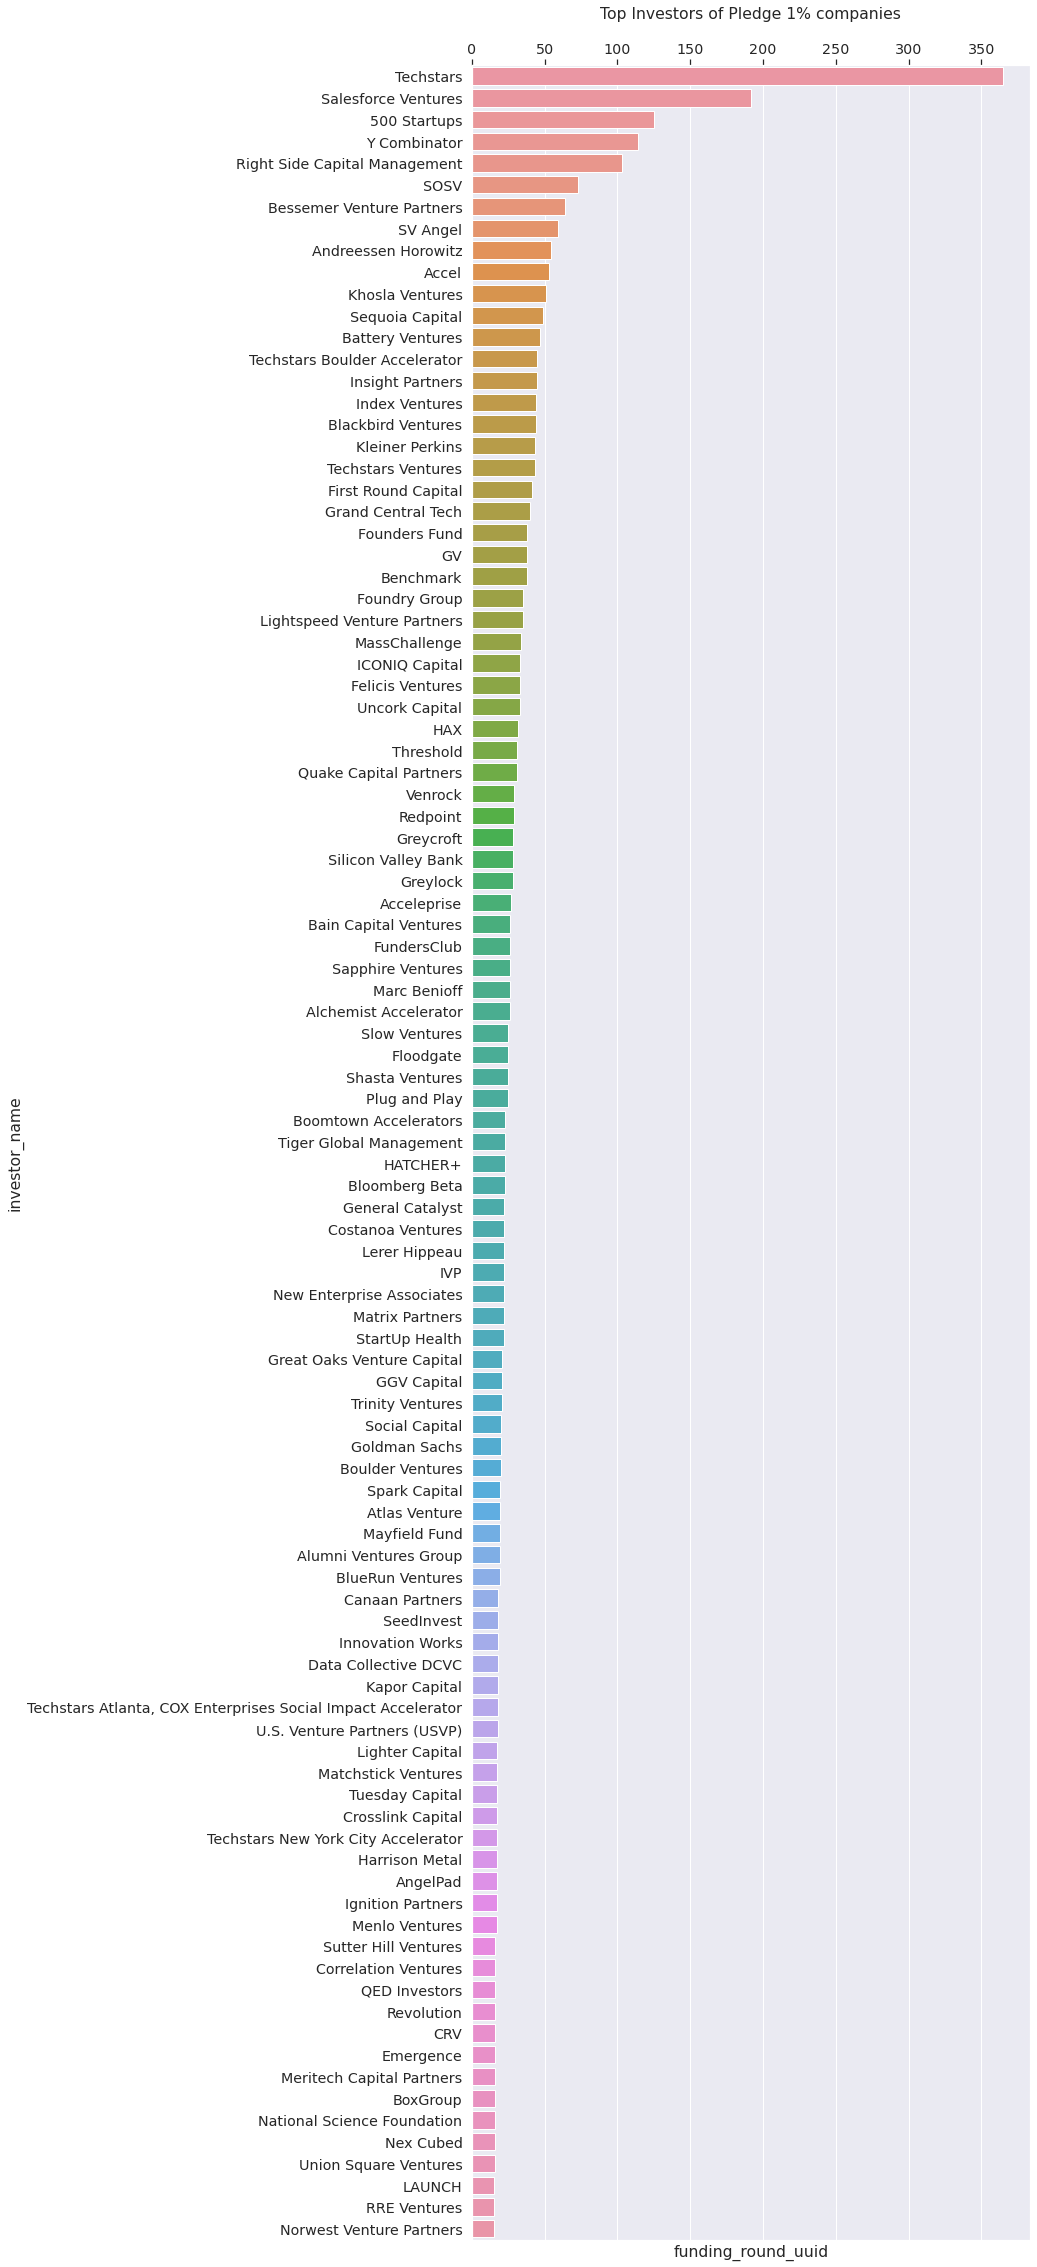

In [105]:
# Plot the graphs
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages

_, ax = plt.subplots(figsize=(10,40), sharey=True)

# p1 investors plot
ax.ticklabel_format(useOffset=False, style='plain')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax.set_title('Top Investors of Pledge 1% companies\n')
ax.xaxis.set_ticks_position("top")
sns.barplot(x='funding_round_uuid', y='investor_name', data=df_p1_100, orient='h', ax=ax)

_.savefig("Top_investing_companies_in_p1_by_counts.pdf", bbox_inches='tight')



In [106]:
# Now create a dataframe for all investors group by investor_name and get count of  funding_round_uuid and lead_count sum
df_p1_all = df_org.groupby('investor_name',as_index=False).agg({"funding_round_uuid":"count","lead_count":"sum"}).\
sort_values('funding_round_uuid',ascending=False)

# merge the above dataset with funds dataset on entity name
df_p1_all['entity_name'] = df_p1_all['investor_name']
df_p1_all_f = pd.merge(df_p1_all.copy(),funds.copy(),how='inner',on='entity_name')


In [107]:
df_p1_all_f.head(1)

,investor_name,funding_round_uuid,lead_count,entity_name,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,entity_uuid,entity_type,announced_on,raised_amount_usd,raised_amount,raised_amount_currency_code
0,Techstars,365,51.0,Techstars,c9c26fc0-0497-d7e3-f701-cbbf2ef2dc5d,Techstars Seattle 2013 Fund,fund,techstars-raised-techstars-seattle-2013-fund--...,https://www.crunchbase.com/fund/techstars-rais...,NaN,2016-02-29 20:58:04,2018-02-13 01:18:08,3718597a-dd39-6661-3630-09cdd43bcac2,organization,2013-01-15,NaN,NaN,NaN


In [108]:
# filter the needed attributes and drop any duplicates
df_p1_all_f = df_p1_all_f[['investor_name','funding_round_uuid','lead_count','raised_amount_usd']]
df_p1_all_f = df_p1_all_f.drop_duplicates()

In [109]:
# Now calculate the raised_amount_usd by grouping on investor_name,funding_round_uuid,lead_count
# and get raised_amount_usd, sorted by raised_amount_usd and write to file
df_p1_all_f['investor_name'].fillna('Not Available', inplace=True)
df_p1_all_f['raised_amount_usd'].fillna(0, inplace=True)
df_p1_all_f = df_p1_all_f.groupby(['investor_name','funding_round_uuid','lead_count'],as_index=False).\
agg({"raised_amount_usd":"sum"}).\
sort_values(['funding_round_uuid','lead_count'],ascending=False)
df_p1_all_f = df_p1_all_f.rename(columns={"raised_amount_usd": "org_raised_amt_usd"})
df_p1_all_f.to_csv('Top_Investing_companies_test.csv')